In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import framework
import utils

In [2]:
DEBUG = False

In [3]:
GAMMA = 0.5  # discounted factor
TRAINING_EP = 0.5  # epsilon-greedy parameter for training
TESTING_EP = 0.05  # epsilon-greedy parameter for testing
NUM_RUNS = 10
NUM_EPOCHS = 200
NUM_EPIS_TRAIN = 25  # number of episodes for training at each epoch
NUM_EPIS_TEST = 50  # number of episodes for testing
ALPHA = 0.1  # learning rate for training


In [4]:
ACTIONS = framework.get_actions()
OBJECTS = framework.get_objects()
NUM_ACTIONS = len(ACTIONS)
NUM_OBJECTS = len(OBJECTS)

In [5]:
def epsilon_greedy(state_1, state_2, q_func, epsilon):
    """Returns an action selected by an epsilon-Greedy exploration policy

    Args:
        state_1, state_2 (int, int): two indices describing the current state
        q_func (np.ndarray): current Q-function
        epsilon (float): the probability of choosing a random command

    Returns:
        (int, int): the indices describing the action/object to take
    """
    # TODO Your code here
    # Toss a coin to decide what to do
    if np.random.binomial(1, epsilon):
        # Randomly choose action and object
        action_index, object_index = np.random.randint(NUM_ACTIONS, size=1), \
                                    np.random.randint(NUM_OBJECTS, size=1)
    else:
        # Choose the best action and object
        action_index, object_index = np.unravel_index(np.argmax(q_func[
                                                                    state_1,
                                                                    state_2,
                                                                    :, :]), 
                                                    (NUM_ACTIONS, NUM_OBJECTS))
    return (int(action_index), int(object_index))


    #action_index, object_index = None, None
    #return (action_index, object_index)

In [6]:
def tabular_q_learning(q_func, current_state_1, current_state_2, action_index,
                       object_index, reward, next_state_1, next_state_2,
                       terminal):
    """Update q_func for a given transition

    Args:
        q_func (np.ndarray): current Q-function
        current_state_1, current_state_2 (int, int): two indices describing the current state
        action_index (int): index of the current action
        object_index (int): index of the current object
        reward (float): the immediate reward the agent recieves from playing current command
        next_state_1, next_state_2 (int, int): two indices describing the next state
        terminal (bool): True if this episode is over

    Returns:
        None
    """
    # TODO Your code here
    if terminal:
        maxQ = 0
    else:
        maxQ = np.max(q_func[next_state_1, next_state_2, :, :])
        
    q_func[current_state_1, current_state_2, action_index,
           object_index] = (1 - ALPHA)*q_func[current_state_1, current_state_2, 
                                               action_index, object_index] + \
                           ALPHA*(reward + GAMMA*maxQ)

    return None  # This function shouldn't return anything

In [7]:
def run_episode(for_training):
    """ Runs one episode
    If for training, update Q function
    If for testing, computes and return cumulative discounted reward

    Args:
        for_training (bool): True if for training

    Returns:
        None
    """
    epsilon = TRAINING_EP if for_training else TESTING_EP

    # initialize for each episode
    '''
    
    epi_reward = 0.0

    (current_room_desc, current_quest_desc, terminal) = framework.newGame()
    
    while not terminal:
        # Choose next action and execute
        current_room_desc_index = dict_room_desc[current_room_desc]
        current_quest_desc_index = dict_quest_desc[current_quest_desc]   # Get room and quest indices
        
        next_action_index, next_object_index = epsilon_greedy(current_room_desc_index,
                                                              current_quest_desc_index,
                                                              q_func,
                                                              epsilon)  # Get next action/object
        
        next_room_desc, next_quest_desc, reward, terminal = framework.step_game(
                                                            current_room_desc, 
                                                            current_quest_desc, 
                                                            next_action_index, 
                                                            next_object_index)  # Take a step
        
        # Only need room index; quest remains same during an episode
        next_room_desc_index = dict_room_desc[next_room_desc] 

        if for_training:
            # update Q-function.
            tabular_q_learning(q_func, current_room_desc_index, current_quest_desc_index, 
                               next_action_index, next_object_index, reward, 
                               next_room_desc_index, current_quest_desc_index,
                               terminal)

        if not for_training:
            # update reward
            epi_reward += (GAMMA**(framework.STEP_COUNT - 1))*reward    

        # prepare next step
        current_room_desc, current_quest_desc = next_room_desc, next_quest_desc

    if not for_training:
        return epi_reward
        
        '''
    epsilon = TRAINING_EP if for_training else TESTING_EP
    gamma_step = 1
    epi_reward = 0

    (current_room_desc, current_quest_desc, terminal) = framework.newGame()
    while not terminal:
        # Choose next action and execute
        cur_room_desc_id = dict_room_desc[current_room_desc]
        cur_quest_desc_id = dict_quest_desc[current_quest_desc]
        (action_index, object_index) = epsilon_greedy(cur_room_desc_id,
                                                      cur_quest_desc_id,
                                                      q_func, epsilon)
        (next_room_desc, next_quest_desc, reward,
         terminal) = framework.step_game(current_room_desc, current_quest_desc,
                                         action_index, object_index)

        if for_training:
            # update Q-function.
            next_room_desc_id = dict_room_desc[next_room_desc]
            next_quest_desc_id = dict_quest_desc[next_quest_desc]
            tabular_q_learning(q_func, cur_room_desc_id, cur_quest_desc_id,
                               action_index, object_index, reward,
                               next_room_desc_id, next_quest_desc_id, terminal)

        if not for_training:
            # update reward
            epi_reward = epi_reward + gamma_step * reward
            gamma_step = gamma_step * GAMMA

        # prepare next step
        current_room_desc = next_room_desc
        current_quest_desc = next_quest_desc

    if not for_training:
        return epi_reward

In [8]:
def run_epoch():
    """Runs one epoch and returns reward averaged over test episodes"""
    rewards = []

    for _ in range(NUM_EPIS_TRAIN):
        run_episode(for_training=True)

    for _ in range(NUM_EPIS_TEST):
        rewards.append(run_episode(for_training=False))

    return np.mean(np.array(rewards))

In [9]:
def run():
    """Returns array of test reward per epoch for one run"""
    global q_func
    q_func = np.zeros((NUM_ROOM_DESC, NUM_QUESTS, NUM_ACTIONS, NUM_OBJECTS))

    single_run_epoch_rewards_test = []
    pbar = tqdm(range(NUM_EPOCHS), ncols=80)
    for _ in pbar:
        single_run_epoch_rewards_test.append(run_epoch())
        pbar.set_description(
            "Avg reward: {:0.6f} | Ewma reward: {:0.6f}".format(
                np.mean(single_run_epoch_rewards_test),
                utils.ewma(single_run_epoch_rewards_test)))
    return single_run_epoch_rewards_test


Avg reward: 0.491541 | Ewma reward: 0.502217: 100%|█| 200/200 [00:02<00:00, 67.2
Avg reward: 0.487643 | Ewma reward: 0.506151: 100%|█| 200/200 [00:03<00:00, 65.1
Avg reward: 0.492253 | Ewma reward: 0.499587: 100%|█| 200/200 [00:02<00:00, 67.6
Avg reward: 0.485238 | Ewma reward: 0.506303: 100%|█| 200/200 [00:03<00:00, 62.8
Avg reward: 0.490565 | Ewma reward: 0.519249: 100%|█| 200/200 [00:02<00:00, 68.9
Avg reward: 0.499387 | Ewma reward: 0.520376: 100%|█| 200/200 [00:02<00:00, 72.7
Avg reward: 0.499035 | Ewma reward: 0.520541: 100%|█| 200/200 [00:02<00:00, 80.3
Avg reward: 0.496397 | Ewma reward: 0.504594: 100%|█| 200/200 [00:02<00:00, 80.8
Avg reward: 0.490744 | Ewma reward: 0.525374: 100%|█| 200/200 [00:02<00:00, 79.5
Avg reward: 0.489642 | Ewma reward: 0.516175: 100%|█| 200/200 [00:02<00:00, 73.9


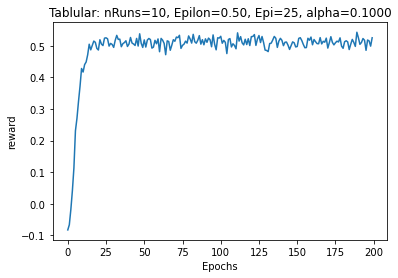

In [10]:
if __name__ == '__main__':
    # Data loading and build the dictionaries that use unique index for each state
    (dict_room_desc, dict_quest_desc) = framework.make_all_states_index()
    NUM_ROOM_DESC = len(dict_room_desc)
    NUM_QUESTS = len(dict_quest_desc)

    # set up the game
    framework.load_game_data()

    epoch_rewards_test = []  # shape NUM_RUNS * NUM_EPOCHS

    for _ in range(NUM_RUNS):
        epoch_rewards_test.append(run())

    epoch_rewards_test = np.array(epoch_rewards_test)

    x = np.arange(NUM_EPOCHS)
    fig, axis = plt.subplots()
    axis.plot(x, np.mean(epoch_rewards_test,
                         axis=0))  # plot reward per epoch averaged per run
    axis.set_xlabel('Epochs')
    axis.set_ylabel('reward')
    axis.set_title(('Tablular: nRuns=%d, Epilon=%.2f, Epi=%d, alpha=%.4f' %
                    (NUM_RUNS, TRAINING_EP, NUM_EPIS_TRAIN, ALPHA)))
    plt.show()
